### Thư viện

In [886]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Auto-ARIMA
from pmdarima import auto_arima

#Scale
from sklearn.preprocessing import MinMaxScaler

#RandomForest
from sklearn.ensemble import RandomForestRegressor

#XGBoost
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

#LSTM
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

#Metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

### Đọc dữ liệu

- Dữ liệu sử dụng giá cổ phiếu cao nhất

#### Dữ liệu Train

- Dữ liệu train từ 2012 đến 2016
- Dữ liệu train có 1258 dòng
- Dữ liệu train giá cổ phiếu cao nhất thiếu 2 ngày T7 và CN đồng thời còn các ngày nghỉ lễ,...

In [787]:
train_data = pd.read_csv('Google_Stock_Price_Train.csv', index_col=0, usecols=['Date','High'])
train_data.head(10)

,High
Date,
1/3/2012,332.83
1/4/2012,333.87
1/5/2012,330.75
1/6/2012,328.77
1/9/2012,322.29
1/10/2012,315.72
1/11/2012,313.52
1/12/2012,315.26
1/13/2012,312.30


In [788]:
train_data.tail(10)

,High
Date,
12/16/2016,800.86
12/19/2016,797.66
12/20/2016,798.65
12/21/2016,796.68
12/22/2016,793.32
12/23/2016,792.74
12/27/2016,797.86
12/28/2016,794.23
12/29/2016,785.93


In [789]:
train_data.shape

(1258, 1)

#### Dữ liệu test

- Dữ liệu test từ 2017
- Dữ liệu test có 20 dòng

In [790]:
test_data = pd.read_csv('Google_Stock_Price_Test.csv', index_col=0, usecols=['Date', 'High'])
test_data.head(10)

,High
Date,
1/3/2017,789.63
1/4/2017,791.34
1/5/2017,794.48
1/6/2017,807.90
1/9/2017,809.97
1/10/2017,809.13
1/11/2017,808.15
1/12/2017,807.39
1/13/2017,811.22


In [791]:
test_data.tail(10)

,High
Date,
1/18/2017,806.21
1/19/2017,809.48
1/20/2017,806.91
1/23/2017,820.87
1/24/2017,825.90
1/25/2017,835.77
1/26/2017,838.00
1/27/2017,841.95
1/30/2017,815.84


In [792]:
test_data.shape

(20, 1)

### Biến đổi dữ liệu

In [793]:
train_data.index = pd.to_datetime(train_data.index)
train_data.head()

,High
Date,
2012-01-03,332.83
2012-01-04,333.87
2012-01-05,330.75
2012-01-06,328.77
2012-01-09,322.29


In [794]:
train_data.shape

(1258, 1)

In [795]:
test_data.index = pd.to_datetime(test_data.index)
test_data.head()

,High
Date,
2017-01-03,789.63
2017-01-04,791.34
2017-01-05,794.48
2017-01-06,807.90
2017-01-09,809.97


In [796]:
test_data.shape

(20, 1)

### Xác định khung thời gian cần sử dụng

In [797]:
train_data = train_data[train_data.index.year >= int(2012)] #Từ 2012
train_data.head()

,High
Date,
2012-01-03,332.83
2012-01-04,333.87
2012-01-05,330.75
2012-01-06,328.77
2012-01-09,322.29


### 1. ARIMA

#### Kiểm tra tính dừng với ADF test

In [798]:
#Kiểm tra tính dừng với ADF test
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: ', result[0])
    print('p_value: ', result[1])
    if (result[1]<0.05): #khoảng tin cậy 95%
        print('Data is stationary')
    else:
        print('Data is not stationary')

In [799]:
adf_test(train_data)

ADF Statistic:  -0.6852442318102282
p_value:  0.8505346822628224
Data is not stationary


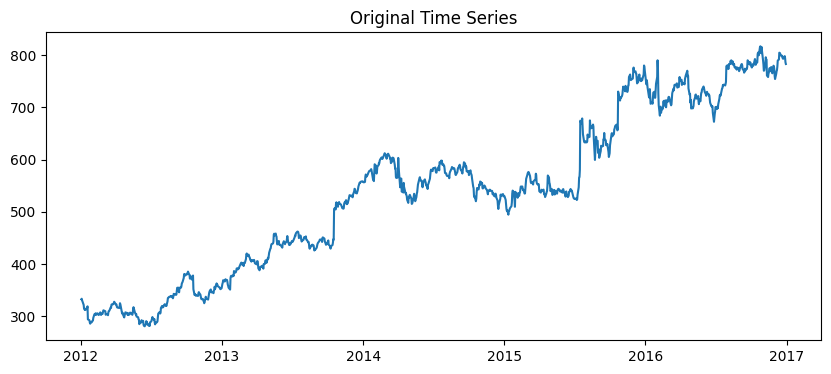

In [800]:
#Kiểm tra tính dừng với biểu đồ chuỗi thời gian
plt.figure(figsize=(10,4))
plt.plot(train_data)
plt.title('Original Time Series')
plt.show()

#### Differencing để dữ liệu có tính dừng

- Sau khi differencing 1 lần, dữ liệu đã có tính dừng nên không cần tiếp tục

ADF Statistic:  -18.934494936573234
p_value:  0.0
Data is stationary


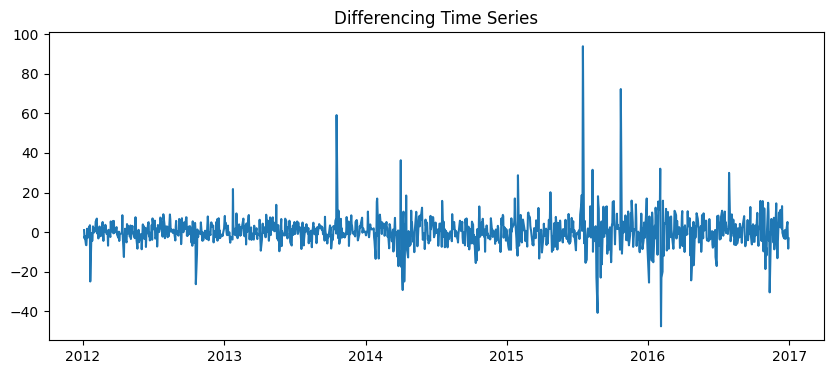

In [801]:
#Differencing lần thứ nhất để dl có tính dừng
diff_series = train_data.diff(1).dropna()
#Kiểm tra tính dừng sau khi differencing
adf_test(diff_series)
#Vẽ biểu đồ chuỗi thời gian sau khi diff
plt.figure(figsize=(10,4))
plt.plot(diff_series)
plt.title('Differencing Time Series')
plt.show()

#### Vẽ biểu đồ ACF và PACF

- Dựa trên biểu đồ PACF, chọn p = 1
- Dựa trên số lần differencing, chọn d = 1
- Dựa trên biểu đồ ACF, chọn q = 1

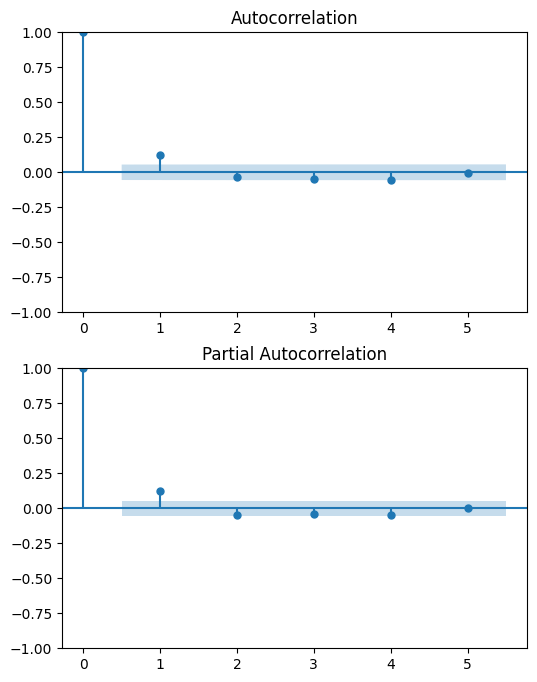

In [802]:
#Chọn lags = 5
fig, ax = plt.subplots(2,1,figsize=(6,8))
plot_acf(diff_series, ax=ax[0], lags=5, alpha=0.05)
plot_pacf(diff_series, ax=ax[1], lags=5, alpha=0.05)
plt.show()

#### Mô hình ARIMA

- AIC = 8621.715

In [803]:
p, d, q = 1,1,1
model = sm.tsa.ARIMA(train_data, order=(p,d,q))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   High   No. Observations:                 1258
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4307.858
Date:                Sun, 17 Nov 2024   AIC                           8621.715
Time:                        20:37:32   BIC                           8637.125
Sample:                             0   HQIC                          8627.507
                               - 1258                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1388      0.162     -0.858      0.391      -0.456       0.178
ma.L1          0.2676      0.161      1.665      0.096      -0.047       0.583
sigma2        55.4960      0.601     92.333      0.0

##### Forecast 20 ngày tiếp theo

In [804]:
forecast = pd.DataFrame(index=test_data.index)
forecast['predicted_mean'] = model_fit.forecast(steps=int(test_data.size)).values
forecast.head()

,predicted_mean
Date,
2017-01-03,782.614309
2017-01-04,782.637306
2017-01-05,782.634114
2017-01-06,782.634557
2017-01-09,782.634496


In [805]:
forecast.tail()

,predicted_mean
Date,
2017-01-25,782.634503
2017-01-26,782.634503
2017-01-27,782.634503
2017-01-30,782.634503
2017-01-31,782.634503


In [806]:
forecast.shape

(20, 1)

#### Đánh giá forecast và tập test

- Biểu đồ cho thấy mô hình hoàn toàn không phù hợp khi forecast chạy ra 1 đường ngang so với tập test
- MAE ~ 29.3 cho thấy sai số tuyệt đối trung bình lệch không nhiều. Tuy nhiên, giá trị forecast lại tập trung quanh giá trị 782 mà không thay đổi cho thấy mô hình không phù hợp.

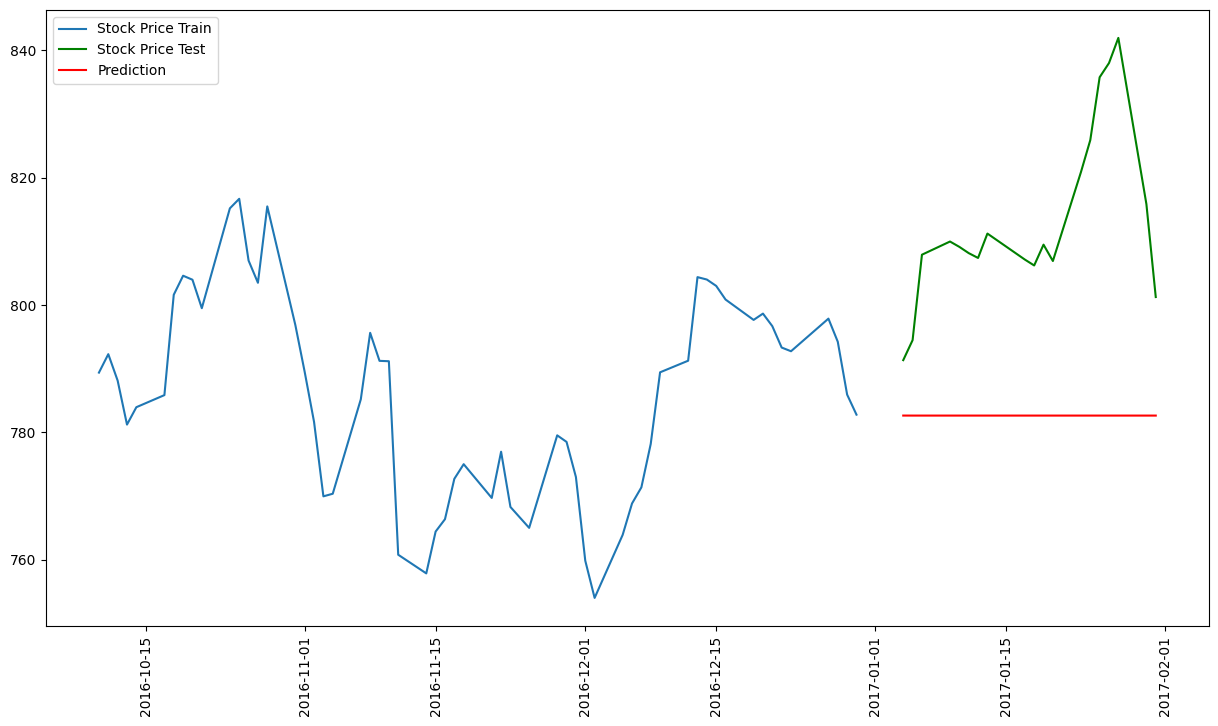

In [807]:
plt.figure(figsize=(15,8))
plt.plot(train_data.iloc[1200:], label='Stock Price Train')
plt.plot(test_data.iloc[1:], label='Stock Price Test', color='green')
plt.plot(forecast.iloc[1:], label='Prediction', color='red')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

In [808]:
mse = mean_squared_error(np.array(test_data['High']), forecast)
mae = mean_absolute_error(np.array(test_data['High']), forecast)
print('MSE:', mse)
print('MAE:', mae)

MSE: 1054.511035937784
MAE: 29.292883378565328


### 2. Auto-ARIMA

- AIC: 8617.342355100074
- Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept

In [809]:
auto_model = auto_arima(train_data,start_p=0, start_q=0, max_p=5, max_q=5,
                         m=1, start_P=0, d=1, D=0, trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8637.970, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8621.505, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8619.985, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8638.827, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8621.365, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=8621.040, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=8617.786, Time=0.29 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8619.341, Time=0.65 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=8619.399, Time=0.54 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=8621.407, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8617.342, Time=0.42 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8620.284, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=8619.341, Time=0.44 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=8620.415, Time=0.30 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept

In [810]:
print('AIC:', auto_model.aic())

AIC: 8617.342355100074


#### Fit mô hình và Predict

In [811]:
auto_model.fit(train_data)

ARIMA(order=(2, 1, 1), scoring_args={}, suppress_warnings=True)

In [812]:
forecast_auto = pd.DataFrame(index=test_data.index)
forecast_auto['Prediction'] = auto_model.predict(n_periods=len(test_data)).values
forecast_auto.head()

,Prediction
Date,
2017-01-03,783.239060
2017-01-04,784.196371
2017-01-05,785.085618
2017-01-06,785.841076
2017-01-09,786.484746


In [813]:
forecast_auto.tail()

,Prediction
Date,
2017-01-25,791.131098
2017-01-26,791.497855
2017-01-27,791.863372
2017-01-30,792.228016
2017-01-31,792.592046


In [814]:
forecast_auto.shape

(20, 1)

#### Đánh giá mô hình 

- MAE(ARIMA): 29.292883378565328
- MAE(Auto-ARIMA): 23.220551785872573
- ==>Đã có sự giảm xuống khoảng 6.3 đơn vị

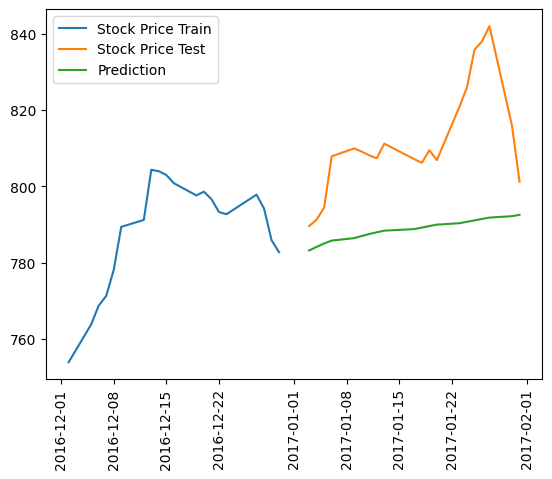

In [815]:
plt.plot(train_data.iloc[-20:], label='Stock Price Train')
plt.plot(test_data, label='Stock Price Test')
plt.plot(forecast_auto, label='Prediction')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

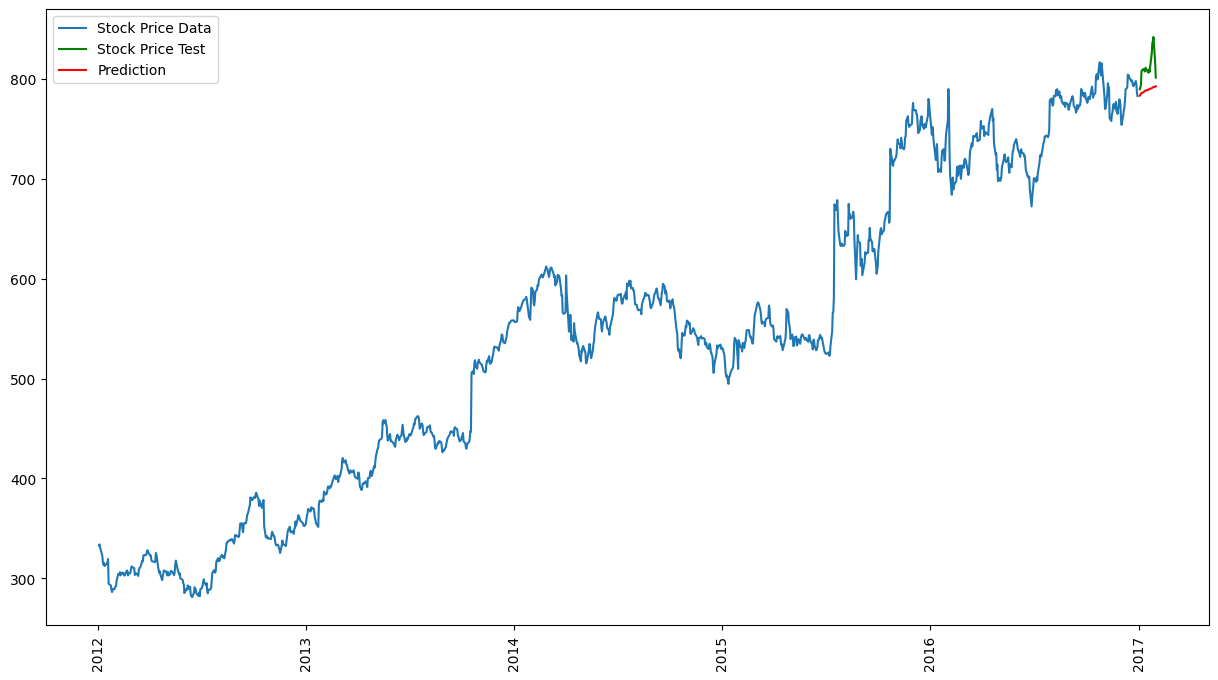

In [816]:
plt.figure(figsize=(15,8))
plt.plot(train_data, label='Stock Price Data')
plt.plot(test_data, label='Stock Price Test', color='green')
plt.plot(forecast_auto, label='Prediction', color='red')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

In [817]:
mse = mean_squared_error(np.array(test_data['High']), forecast_auto)
mae = mean_absolute_error(np.array(test_data['High']), forecast_auto)
print('MSE:', mse)
print('MAE:', mae)

MSE: 689.2868065681616
MAE: 23.220551785872573


### Machine Learning

#### Chuẩn bị dữ liệu

- Chọn tập train_data(google stock price train.csv) để học

In [818]:
scaler = MinMaxScaler()
full_data = scaler.fit_transform(train_data)

In [819]:
def create_dataset(data, time_steps):
    X, y = [], []
    for i in range(len(data)-time_steps):
        X.append(data[i:(i+time_steps)])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

In [820]:
X, y = create_dataset(np.array(full_data), 7) #chọn time_steps = 7

In [821]:
def train_test_split_series(X, y, train_size):
    train_size = int(len(X)*train_size)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    return X_train, X_test, y_train, y_test

In [822]:
X_train, X_test, y_train, y_test = train_test_split_series(X, y, 0.8)

In [823]:
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (1000, 7, 1)
X_test shape:  (251, 7, 1)
y_train shape:  (1000, 1)
y_test shape:  (251, 1)


In [824]:
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)
print('X_train_reshaped shape: ', X_train_reshaped.shape)
print('X_test_reshaped shape: ', X_test_reshaped.shape)
y_train_flattened = y_train.reshape(-1)
y_test_flattened = y_test.reshape(-1)
print('y_train_flattened shape: ', y_train_flattened.shape)
print('y_test_flattened shape: ', y_test_flattened.shape)

X_train_reshaped shape:  (1000, 7)
X_test_reshaped shape:  (251, 7)
y_train_flattened shape:  (1000,)
y_test_flattened shape:  (251,)


#### RandomForest và Đánh giá

- MAE = 16.12004621513959 nhỏ hơn nhiều so với Auto-ARIMA(23.220551785872573) và ARIMA(29.292883378565328)

In [825]:
RF_model = RandomForestRegressor(n_jobs=-1)
RF_model.fit(X_train_reshaped, y_train_flattened)

RandomForestRegressor(n_jobs=-1)

In [826]:
y_pred = RF_model.predict(X_test_reshaped)

In [827]:
y_predict_actual = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
mse = mean_squared_error(y_test_actual, y_predict_actual)
mae = mean_absolute_error(y_test_actual, y_predict_actual)
print (f"Mean Squared Error: {mse}")
print (f"Mean Absolute Error: {mae}")

Mean Squared Error: 400.03233425944916
Mean Absolute Error: 16.12004621513959


- Biểu đồ đường test của tập train(google stock price train.csv) và Biểu đồ đường predict tập test của tập train(google stock price train) tuy vẫn còn sai lệch nhưng đã bắt được những đoạn gợn sóng

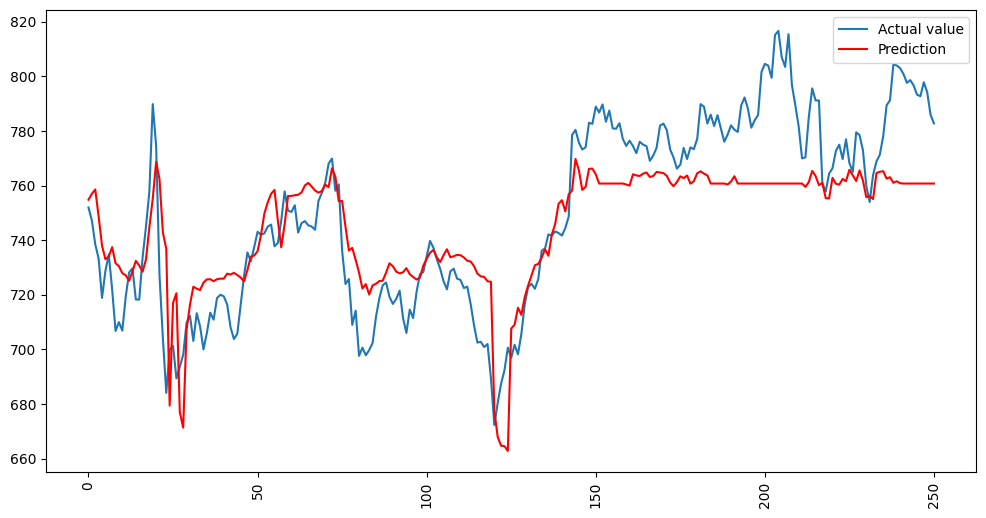

In [828]:
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label='Actual value')
plt.plot(y_predict_actual, label='Prediction', color='red')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

##### Dự đoán 20 giá trị tiếp theo để so với tập test(google stock price test.csv)

- MAE: 54.891255000000136

In [831]:
test_points_rf = np.array(train_data[-7:])
test_points_rf = scaler.transform(np.array(test_points_rf).reshape(-1, 1)).flatten()
new_prediction_points_rf = []
for _ in range(20):
    test_seq = test_points_rf.reshape(1, -1)
    next_prediction = RF_model.predict(test_seq)
    new_prediction_points_rf.append(next_prediction[0])    
    test_points_rf = np.append(test_points_rf[1:], next_prediction)
new_predictions_actual_rf = scaler.inverse_transform(np.array(new_prediction_points_rf).reshape(-1, 1))
print("Next 20 predicted values:", new_predictions_actual_rf.flatten())

Next 20 predicted values: [760.7558 755.2266 754.2605 754.4565 755.5671 762.083  761.3774 759.8029
 758.1456 754.3586 752.4391 755.36   758.8482 761.303  760.1553 758.7498
 754.6061 752.8974 753.1993 757.1127]


In [832]:
mse = mean_squared_error(np.array(test_data['High']), new_predictions_actual_rf)
mae = mean_absolute_error(np.array(test_data['High']), new_predictions_actual_rf)
print (f"Mean Squared Error: {mse}")
print (f"Mean Absolute Error: {mae}")

Mean Squared Error: 3226.4788333265124
Mean Absolute Error: 54.891255000000136


In [833]:
new_predictions_actualrf_df = pd.DataFrame(index=test_data.index)
new_predictions_actualrf_df['High'] = new_predictions_actual_rf
new_predictions_actualrf_df.head()

,High
Date,
2017-01-03,760.7558
2017-01-04,755.2266
2017-01-05,754.2605
2017-01-06,754.4565
2017-01-09,755.5671


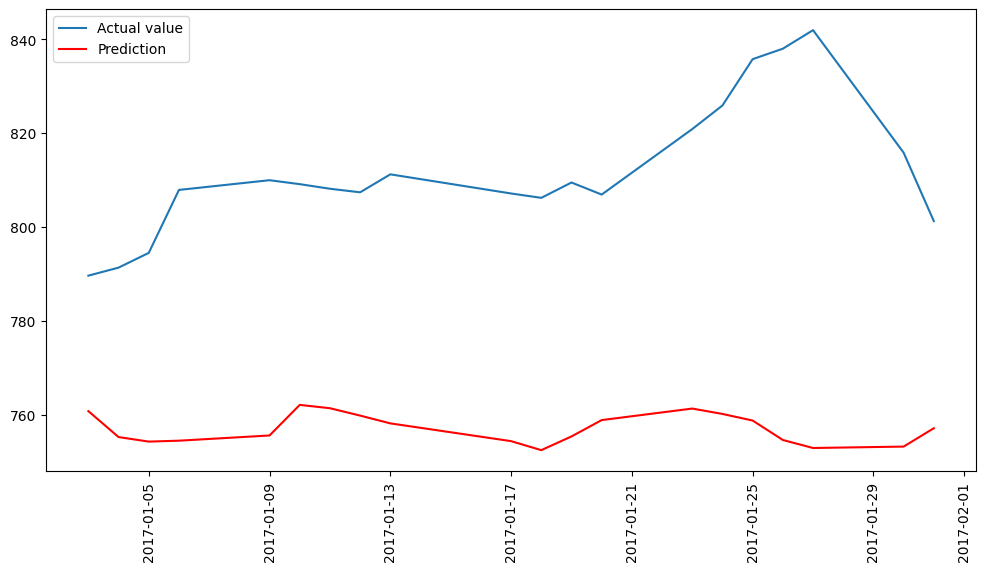

In [834]:
plt.figure(figsize=(12,6))
plt.plot(test_data['High'], label='Actual value')
plt.plot(new_predictions_actualrf_df['High'], label='Prediction', color='red')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

#### XGBoost và Đánh giá

##### GridSearch parameter XGBoost

In [835]:
param_grid = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.1, 0.01],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'objective': ['reg:squarederror', 'reg:squaredlogerror']
}
model = xgb.XGBRegressor()
grid_search = GridSearchCV(estimator= model, param_grid=param_grid, scoring='r2', cv=5, n_jobs=-1)
grid_search.fit(X_train_reshaped, y_train_flattened)
print(grid_search.best_score_)

0.5794634609254691


##### Fit XGBoost và Đánh giá

- MAE = 16.697791393021664 nhỏ thứ 2 sau RandomForest(16.12004621513959) và nhỏ hơn nhiều so với Auto-ARIMA(23.220551785872573) và ARIMA(29.292883378565328)

In [836]:
best_xgb = grid_search.best_estimator_

In [837]:
y_pred = best_xgb.predict(X_test_reshaped)

In [839]:
y_predict_actual = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
mse = mean_squared_error(y_test_actual, y_predict_actual)
mae = mean_absolute_error(y_test_actual, y_predict_actual)
print (f"Mean Squared Error: {mse}")
print (f"Mean Absolute Error: {mae}")

Mean Squared Error: 420.36255108721986
Mean Absolute Error: 16.697791393021664


- Biểu đồ đường test của tập train(google stock price train.csv) và Biểu đồ đường predict tập test của tập train(google stock price train) tuy vẫn còn sai lệch nhưng đã bắt được những đoạn gợn sóng có vẻ tốt hơn so với RandomForest

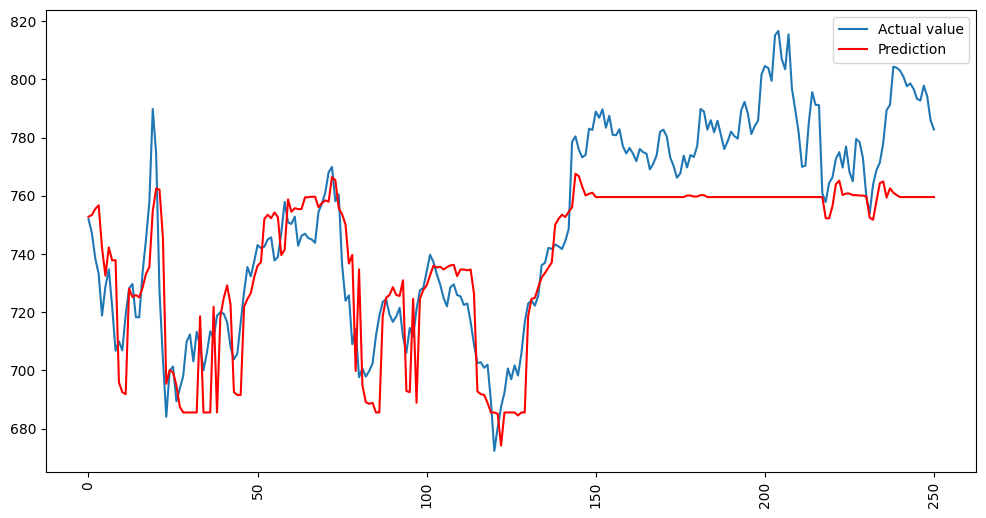

In [840]:
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label='Actual value')
plt.plot(y_predict_actual, label='Prediction', color='red')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

##### Dự đoán 20 giá trị tiếp theo để so với tập test(google stock price test.csv)

- MAE = 54.91098791503907 chỉ cao hơn 1 chút không đáng kể so với của RF(54.891255000000136)

In [841]:
test_points_xg = np.array(train_data[-7:])
test_points_xg = scaler.transform(np.array(test_points_xg).reshape(-1, 1)).flatten()
new_prediction_points_xg = []
for _ in range(20):
    test_seq = test_points_xg.reshape(1, -1)
    next_prediction = best_xgb.predict(test_seq)
    new_prediction_points_xg.append(next_prediction[0])    
    test_points_xg = np.append(test_points_xg[1:], next_prediction)
new_predictions_actual_xg = scaler.inverse_transform(np.array(new_prediction_points_xg).reshape(-1, 1))
print("Next 20 predicted values:", new_predictions_actual_xg.flatten())

Next 20 predicted values: [759.55365 752.2671  751.0887  751.7455  756.0238  760.96063 759.76654
 760.7279  758.905   756.55054 755.1131  753.75916 756.5291  761.8963
 761.15076 761.0244  758.1411  756.2347  755.1131  753.75916]


In [842]:
mse = mean_squared_error(np.array(test_data['High']), new_predictions_actual_xg)
mae = mean_absolute_error(np.array(test_data['High']), new_predictions_actual_xg)
print (f"Mean Squared Error: {mse}")
print (f"Mean Absolute Error: {mae}")

Mean Squared Error: 3184.5627023444877
Mean Absolute Error: 54.91098791503907


In [843]:
new_predictions_actual_xg_df = pd.DataFrame(index=test_data.index)
new_predictions_actual_xg_df['High'] = new_predictions_actual_xg
new_predictions_actual_xg_df.head()

,High
Date,
2017-01-03,759.553650
2017-01-04,752.267090
2017-01-05,751.088684
2017-01-06,751.745483
2017-01-09,756.023804


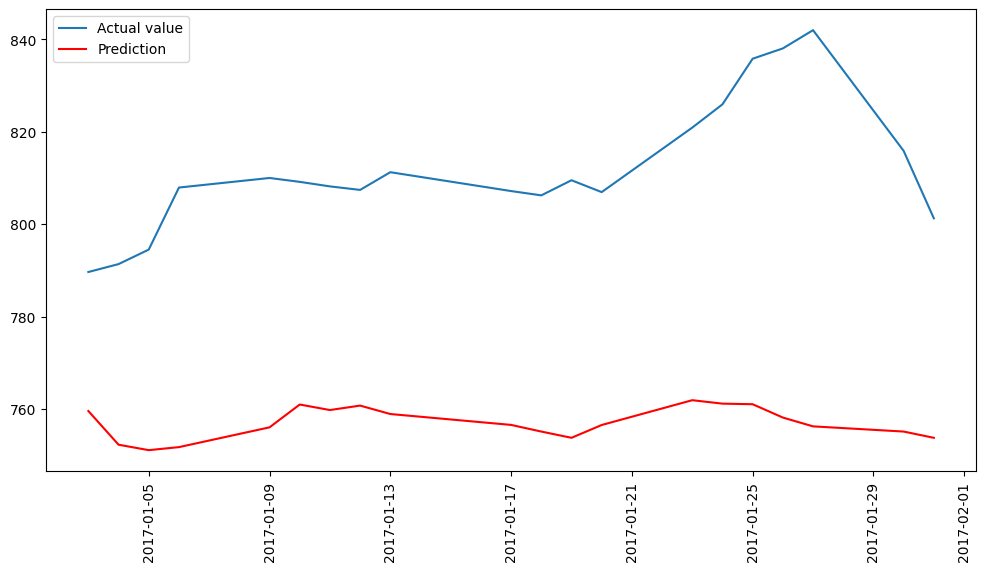

In [845]:
plt.figure(figsize=(12,6))
plt.plot(test_data['High'], label='Actual value')
plt.plot(new_predictions_actual_xg_df['High'], label='Prediction', color='red')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

### Deep Learning

#### LSTM

##### Chuẩn bị lại tập dữ liệu(nếu cần)

In [887]:
scaler = MinMaxScaler()
full_data = scaler.fit_transform(train_data)
def create_dataset(data, time_steps):
    X, y = [], []
    for i in range(len(data)-time_steps):
        X.append(data[i:(i+time_steps)])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)
X, y = create_dataset(np.array(full_data), 7) #chọn time_steps = 7
def train_test_split_series(X, y, train_size):
    train_size = int(len(X)*train_size)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split_series(X, y, 0.8)

##### LSTM và Đánh giá

- MAE = 7.894457336668948 giảm mạnh rõ rệt nhất so với tất cả MAE của mô hình ở trên.
- LSTM(5.930254966462278) < RF(16.12004621513959) < XGB(16.697791393021664) < Auto-ARIMA(23.220551785872573) < ARIMA(29.292883378565328).

In [888]:
#X_train.shape[1] = 7
lstm_model = Sequential()
lstm_model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(25))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, batch_size=16, epochs=200)

Epoch 1/200
63/63 [==============================] - 3s 7ms/step - loss: 0.0135
Epoch 2/200
63/63 [==============================] - 0s 7ms/step - loss: 0.0024
Epoch 3/200
63/63 [==============================] - 0s 7ms/step - loss: 0.0021
Epoch 4/200
63/63 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 5/200
63/63 [==============================] - 0s 7ms/step - loss: 0.0016
Epoch 6/200
63/63 [==============================] - 0s 7ms/step - loss: 0.0017
Epoch 7/200
63/63 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 8/200
63/63 [==============================] - 0s 7ms/step - loss: 0.0015
Epoch 9/200
63/63 [==============================] - 0s 7ms/step - loss: 0.0015
Epoch 10/200
63/63 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 11/200
63/63 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 12/200
63/63 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 13/200
63/63 [=================

In [889]:
y_predict_lstm = lstm_model.predict(X_test)
y_predict_actual_lstm = scaler.inverse_transform(y_predict_lstm.reshape(-1,1))
y_test_actual_lstm = scaler.inverse_transform(y_test.reshape(-1,1))
mse = mean_squared_error(y_test_actual_lstm, y_predict_actual_lstm)
mae = mean_absolute_error(y_test_actual_lstm, y_predict_actual_lstm)
r2 = r2_score(y_test_actual_lstm, y_predict_actual_lstm)
print (f"Mean Squared Error: {mse}")
print (f"Mean Absolute Error: {mae}")
print (f"R² Score: {r2}")

8/8 [==============================] - 1s 3ms/step
Mean Squared Error: 108.63632977791629
Mean Absolute Error: 7.894457336668948
R² Score: 0.9051213766066746


- Biểu đồ đường test của tập train(google stock price train.csv) và Biểu đồ đường predict tập test của tập train(google stock price train.csv) tuy vẫn còn sai lệch nhỏ nhưng đã bắt được những đoạn gợn sóng tốt hơn so với XGBoost và RandomForest khá nhiều.

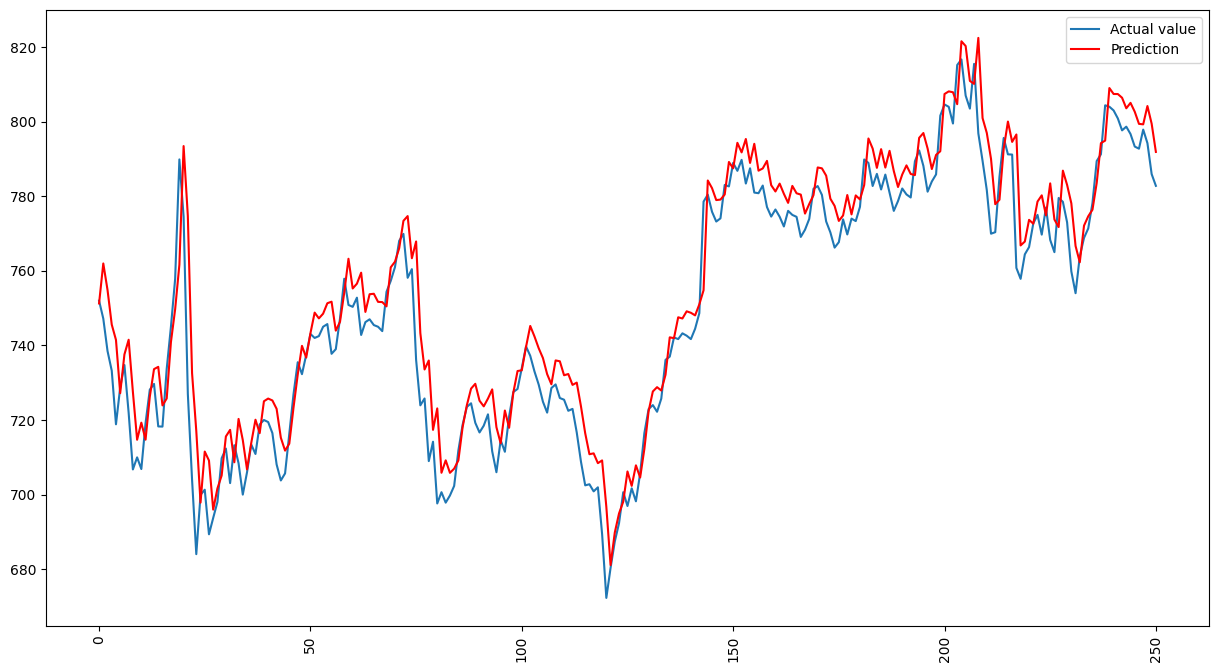

In [890]:
plt.figure(figsize=(15,8))
plt.plot(y_test_actual_lstm, label='Actual value')
plt.plot(y_predict_actual_lstm, label='Prediction', color='red')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

##### Dự đoán 20 giá trị tiếp theo để so với tập test(google stock price test.csv)

- MAE = 22.487820312797947 thấp đi nhiều so với XGB(54.91098791503907) và RF(55.261705000000084)

In [891]:
test_points_lstm = np.array(train_data.High[-7:]) #Lấy 7 dữ liệu cuối từ train
test_points_lstm = scaler.transform(np.array(test_points_lstm).reshape(-1, 1)) #Scale
test_points_lstm = test_points_lstm.flatten().tolist() #Chuyển lại thành list
print("Initial test_points (scalar values):", test_points_lstm)
for _ in range(20):
    test_seq = np.array(test_points_lstm[-7:]).reshape(1, 7, 1)
    next_prediction = lstm_model.predict(test_seq).astype(np.float64)
    test_points_lstm.append(next_prediction[0][0])
print("Cập nhật các điểm dự đoán:", test_points_lstm)
y_test_predicted_lstm = test_points_lstm[-20:]
y_test_predicted_lstm = scaler.inverse_transform(np.array(y_test_predicted_lstm).reshape(-1,1))
print('Dự đoán giá trị 12 tháng tiếp theo: ', y_test_predicted_lstm)

Initial test_points (scalar values): [0.9626496349001811, 0.9563747735634117, 0.9552916129755168, 0.9648533064410706, 0.9580742151754534, 0.9425738136590284, 0.9366911311558069]
1/1 [==============================] - 0s 21ms/step
Cập nhật các điểm dự đoán: [0.9626496349001811, 0.9563747735634117, 0.9552916129755168, 0.9648533064410706, 0.9580742151754534, 0.9425738136590284, 0.9366911311558069, 0.950340747833252, 0.9637422561645508, 0.973867654800415, 0.982184886932373, 0.9903602600097656, 0.9986035823822021, 1.006842851638794, 1.0150368213653564, 1.0231400728225708, 1.0311232805252075, 1.0389817953109741, 1.0467227697372437, 1.0543500185012817, 1.0618630647659302, 1.0692600011825562, 1.0765398740768433, 1.083701491355896, 1.0907444953918457, 1.0976682901382446, 1.1044725179672241]
Dự đoán giá trị 12 tháng tiếp theo:  [[790.08896024]
 [797.26506591]
 [802.68691312]
 [807.14054141]
 [811.51820843]
 [815.93226026]
 [820.34414177]
 [824.73176674]
 [829.07081479]
 [833.34558302]
 [837.5535

In [892]:
mse = mean_squared_error(np.array(test_data['High']), y_test_predicted_lstm)
mae = mean_absolute_error(np.array(test_data['High']), y_test_predicted_lstm)
print (f"Mean Squared Error: {mse}")
print (f"Mean Absolute Error: {mae}")

Mean Squared Error: 812.2622460357773
Mean Absolute Error: 22.487820312797947


In [893]:
new_predictions_actual_lstm_df = pd.DataFrame(index=test_data.index)
new_predictions_actual_lstm_df['High'] = y_test_predicted_lstm
new_predictions_actual_lstm_df.head()

,High
Date,
2017-01-03,790.088960
2017-01-04,797.265066
2017-01-05,802.686913
2017-01-06,807.140541
2017-01-09,811.518208


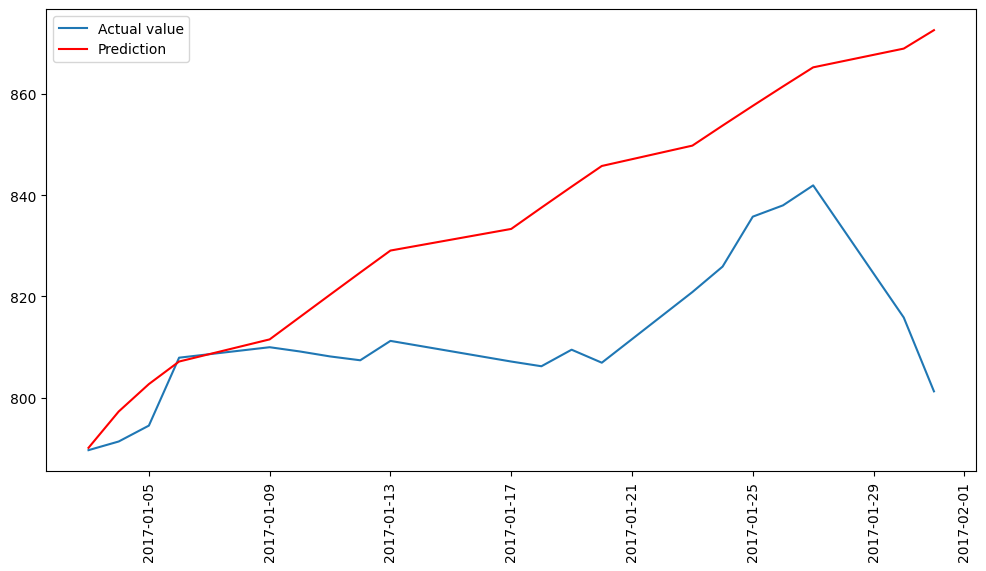

In [894]:
plt.figure(figsize=(12,6))
plt.plot(test_data['High'], label='Actual value')
plt.plot(new_predictions_actual_lstm_df['High'], label='Prediction', color='red')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()